In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
sys.path.append("../src/utils")
import annovar_utils
from annovar_utils import get_value_from_info

# 1A. Healthy persons contains many stopgain variants.

In [3]:
_1KG_dir = "/cluster/u/rrastogi/ECNN/dataset/1KG/phase_join"

afs_list = []
num_homos_list = []
num_hets_list = []

for chrom in list(range(1, 23)) + ["X", "Y"]:
    filepath = os.path.join(_1KG_dir, "chr{}_stopgain_join.tsv".format(chrom))
    for line in open(filepath):
        row = line.strip().split('\t')
        af_string = get_value_from_info(row[7], "AF", str)
        afs = list(map(float, af_string.split(',')))
        for i, af in enumerate(afs):
            afs_list.append(af)
            num_homos_list.append(0)
            num_hets_list.append(0)
            
            alt_index = i + 1
            for gt in row[9: ]:
                if gt in ["{}|{}".format(alt_index, alt_index), "{}".format(alt_index)]:
                    num_homos_list[-1] += 1
                elif gt in ["{}|{}".format(0, alt_index), "{}|{}".format(alt_index, 0)]:
                    num_hets_list[-1] += 1

afs_arr = np.asarray(afs_list)
num_homos_arr = np.asarray(num_homos_list)
num_hets_arr = np.asarray(num_hets_list)
num_stopgains_arr = num_homos_arr + num_hets_arr

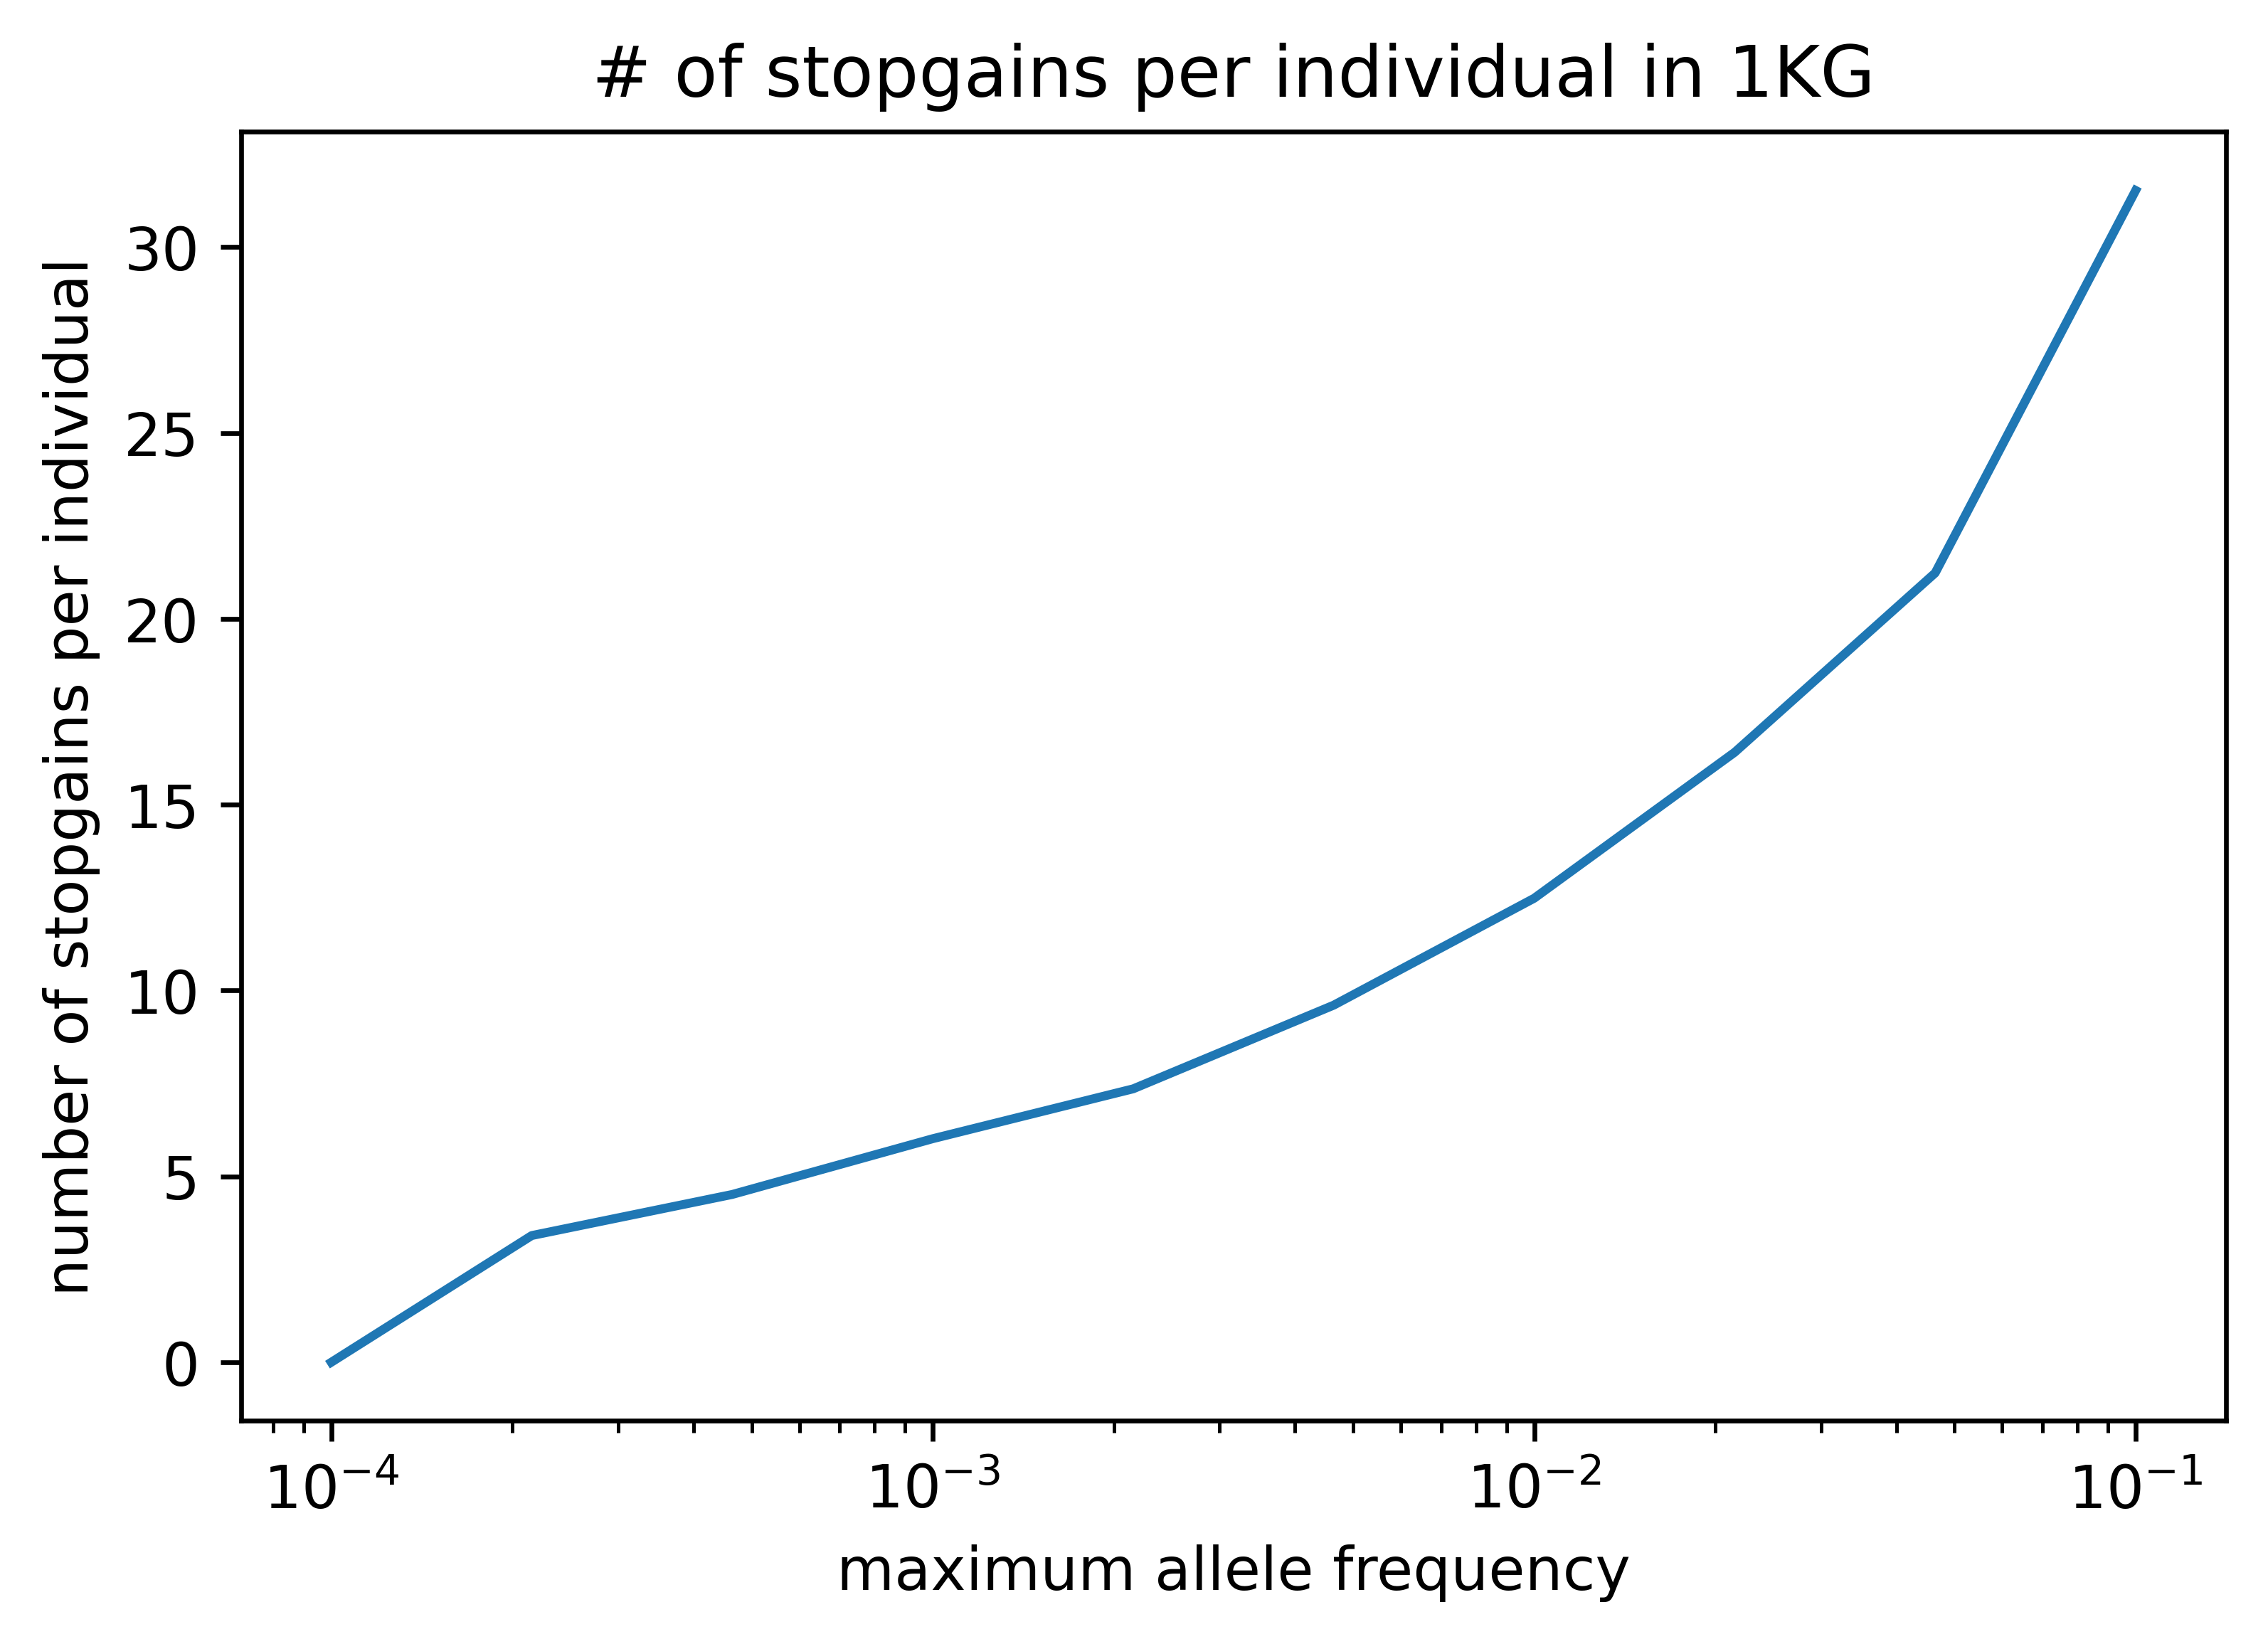

Specific values at an AF threshold of 0.01
Num homozygotes: 0.15535143769968052
Num heterozygotes: 12.32867412140575


In [4]:
afs_x = []
num_homos_y = []
num_hets_y = []
num_stopgains_y = []

NS = 2504

for num in np.logspace(-4, -1, 10):
    afs_x.append(num)
    num_homos_y.append(np.sum(num_homos_arr[afs_arr <= num]) / NS)
    num_hets_y.append(np.sum(num_hets_arr[afs_arr <= num]) / NS)
    num_stopgains_y.append(np.sum(num_stopgains_arr[afs_arr <= num]) / NS)

plt.figure(dpi=600)
plt.plot(afs_x, num_stopgains_y)
plt.xscale('log')
plt.xlabel("maximum allele frequency")
plt.ylabel("number of stopgains per individual")
plt.title("# of stopgains per individual in 1KG")
plt.show()

print("Specific values at an AF threshold of 0.01")
print("Num homozygotes: {}".format(np.sum(num_homos_arr[afs_arr <= 0.01]) / NS))
print("Num heterozygotes: {}".format(np.sum(num_hets_arr[afs_arr <= 0.01]) / NS))

# 1B. Stopgains are the third largest category in HGMD.

In [5]:
from collections import defaultdict
import matplotlib.pyplot as plt

hgmd_2020_path = "/cluster/u/rrastogi/ECNN/dataset/hgmd_2020/annovar_output/hgmd.exonic_variant_function"

counts_by_variant_type = defaultdict(int)
for line in open(hgmd_2020_path):
    row = line.strip().split('\t')
    if "=DM;" not in row[-1]:
        continue
    variant_type = row[1]
    counts_by_variant_type[variant_type] += 1
    
general_category_to_components = {
    "missense": ["nonsynonymous SNV"],
    "frameshift indel": ["frameshift insertion", "frameshift deletion"],
    "stopgain": ["stopgain"],
    "other": ["nonframeshift deletion", "nonframeshift insertion", "nonframeshift substitution",
              "frameshift substitution", "synonymous SNV", "stoploss", "unknown"]
}

counts_by_general_variant_type = defaultdict(int)
for k, v in general_category_to_components.items():
    general_counts = sum([counts_by_variant_type[type_] for type_ in v])
    counts_by_general_variant_type[k] = general_counts

labels = []
sizes = []
explode = []
for category, counts in counts_by_general_variant_type.items():
    labels.append(category)
    sizes.append(counts)
    explode.append(0) 

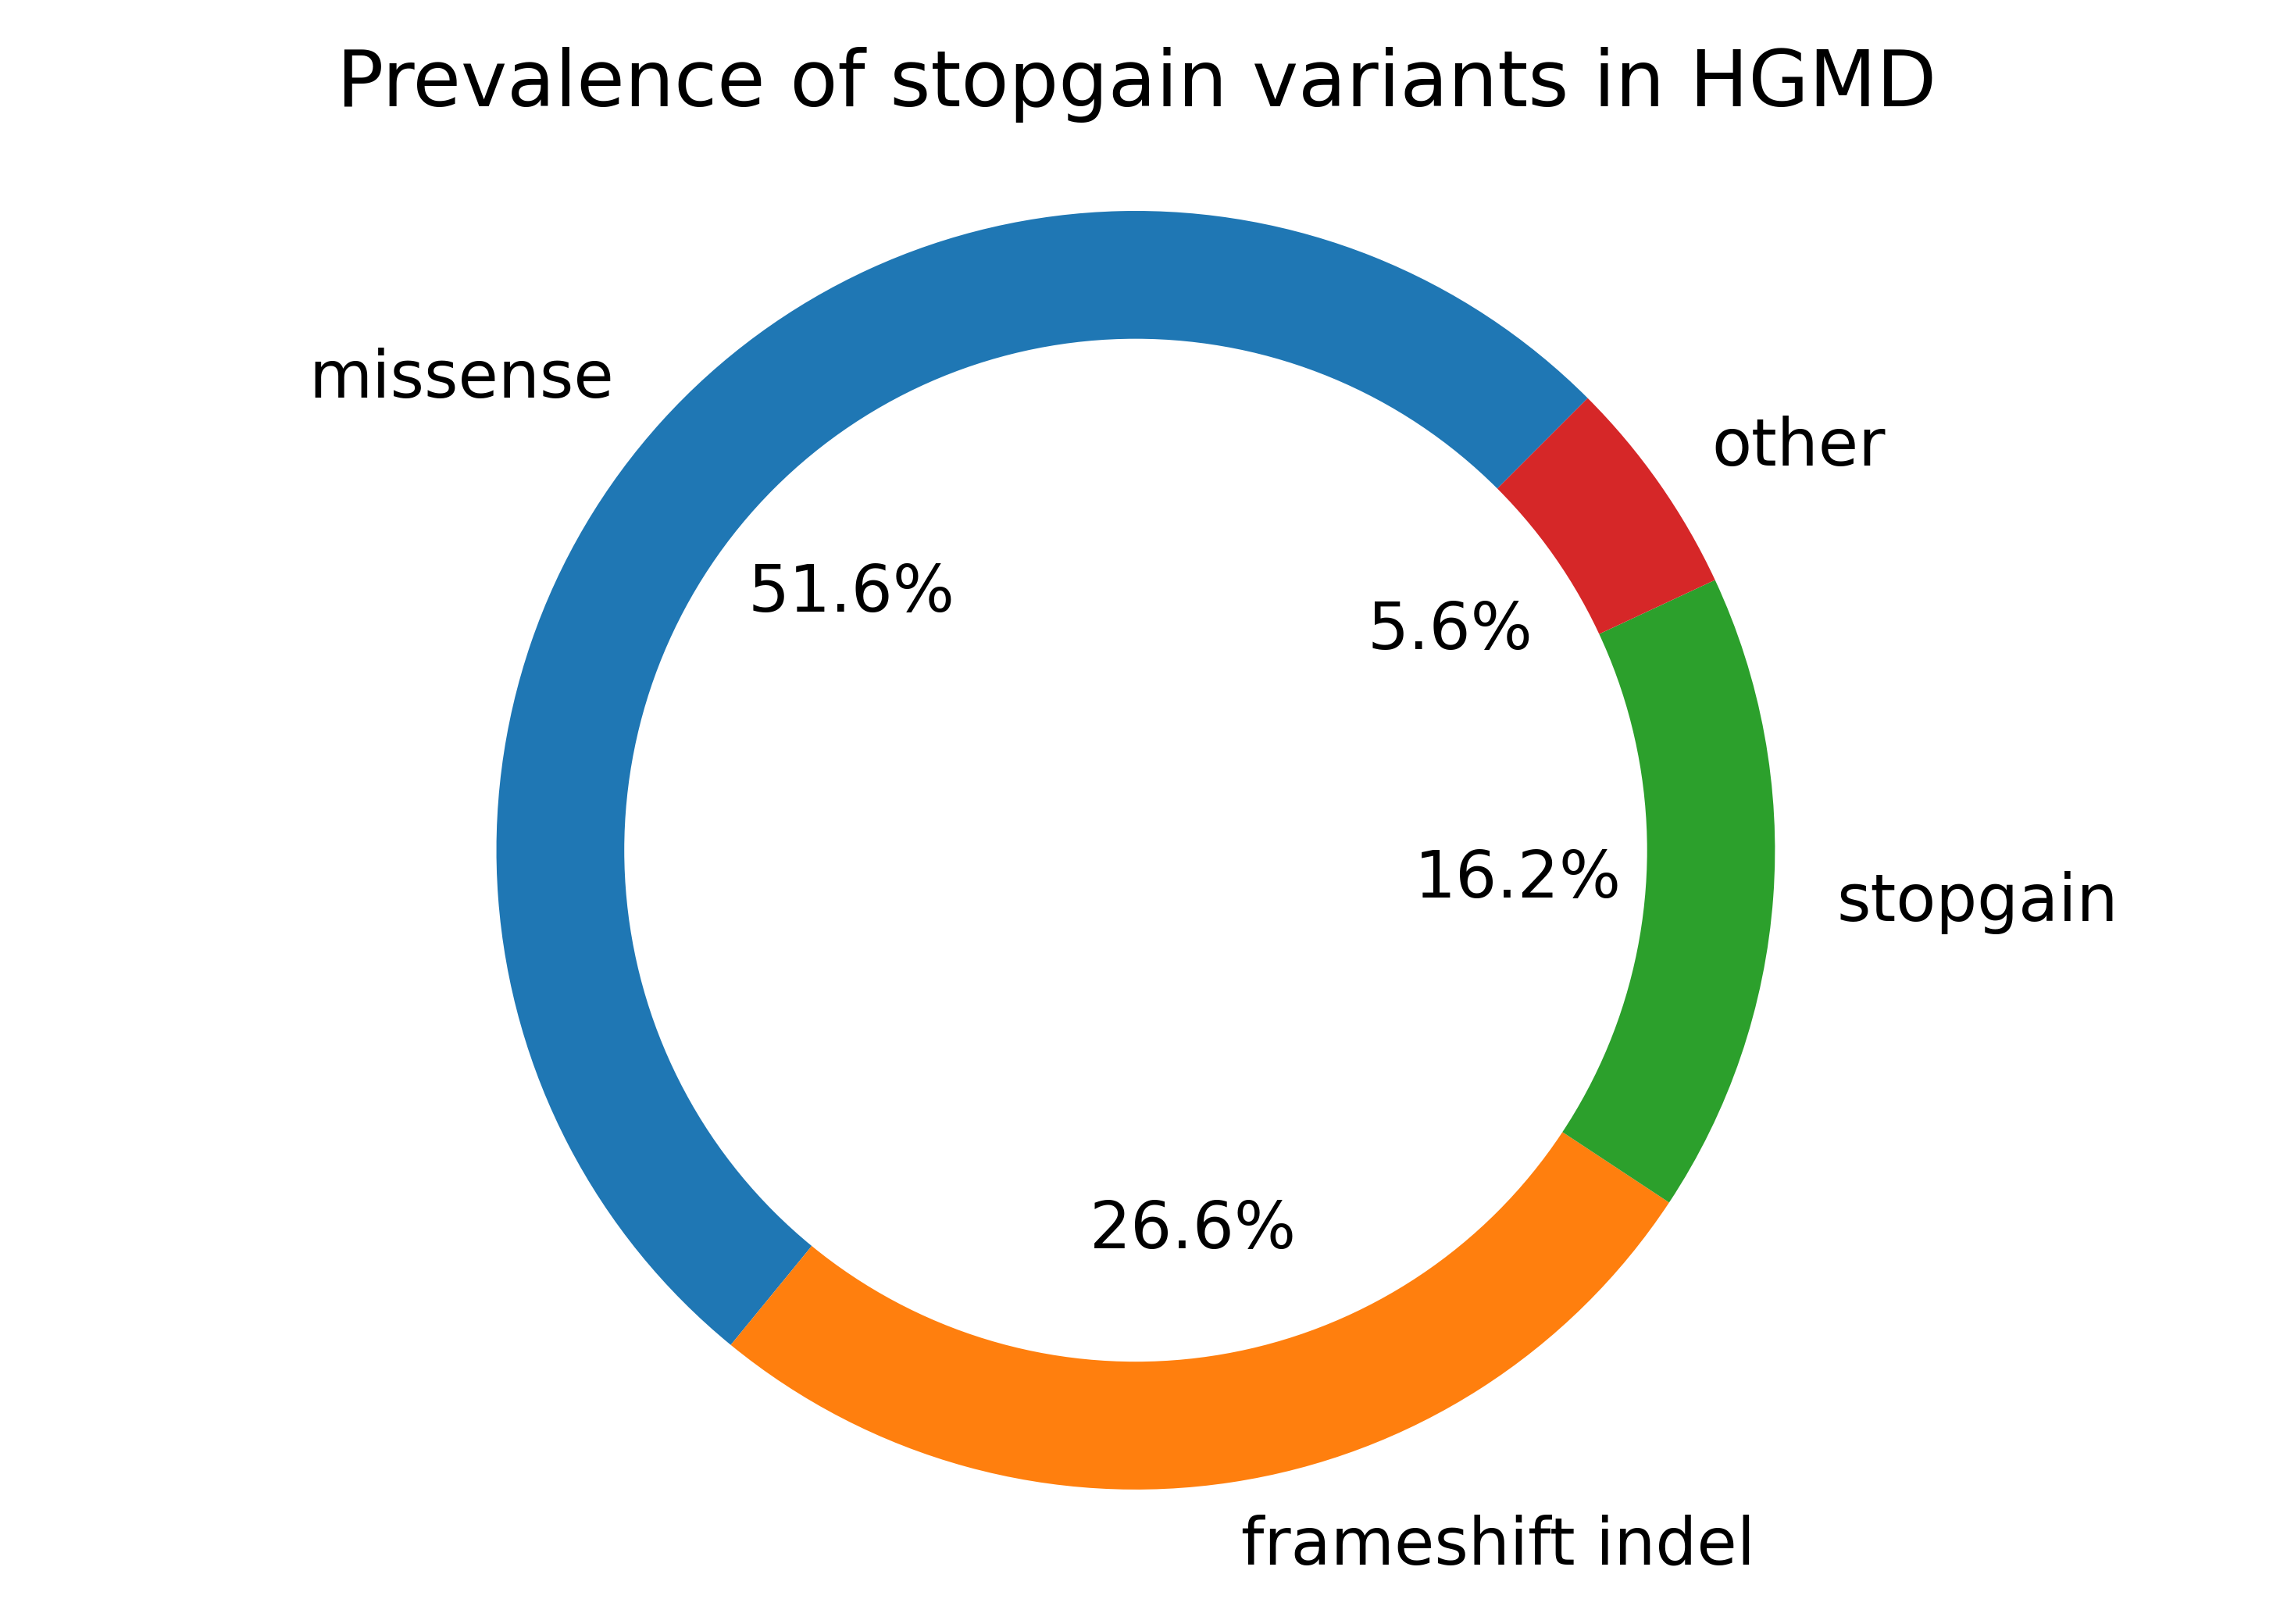

In [6]:
plt.figure(dpi=600)
plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=45)
centre_circle = plt.Circle((0,0),0.80,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.axis("equal")
plt.title("Prevalence of stopgain variants in HGMD")
plt.show()